# Outliers ranking stability

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import matplotlib.pyplot as plt
plt.set_cmap('Blues')
%matplotlib inline

from simforest import SimilarityForestClassifier
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.datasets import fetch_kddcup99, fetch_openml, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.utils import shuffle as sh

In this notebook I am going to show how stable outliers ranking in Similarity Forest is, depending on number of sub-estimators. First, the ranking is constructed using just a single tree. Number of outliers is obtained. At each following iteration the ranking is recalculated using more trees. This result is then compared with previous one using Spearman ranked correlation.

Similarity Forest is compared with Isolation Forest. Experiment is performed on three standard outlier deteciton datasets. On two of them models perform comparatively, but on the last one Similarity Forest performs worse.

# KDDCup99 dataset

First, I use http subset of KDDCup99 dataset. It consists of different kinds of cyberattacks, but I am only interested whenever attack has happened or not 

In [2]:
X, y = fetch_kddcup99(subset='http', random_state=42, return_X_y=True)
X, y = X.astype(np.float32), y.astype('str')

# fix classes
y_df = pd.DataFrame(y, columns=['class'])
y_df.loc[y_df['class'] != 'normal.', 'class'] = -1
y_df.loc[y_df['class'] == 'normal.', 'class'] = 1
y = y_df.values

# split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Class distribution

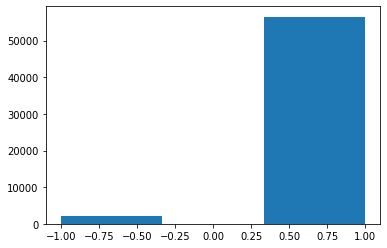

In [3]:
plt.hist(y, bins=3);

Models are trained. For each sub-estimator in both forest I use a subsample of 256, just like in Isolation Forest paper. Furthermore, each tree is grown to the max depth 8, because it should be enough to isolate abnormal instances from normal instances.

In [7]:
max_samples = 256
max_depth = int(np.ceil(np.log2(max(max_samples, 2))))
SF = SimilarityForestClassifier(random_state=42, n_estimators=100, bootstrap=False, max_samples=max_samples,
                                max_depth=max_depth, discriminative_sampling=False, most_different=False)
SF.fit(X_train, y_train)
SF_preds = SF.predict_outliers(X_test)

IF = IsolationForest(random_state=42, behaviour='new')
IF.fit(X_train, y_train)
IF_preds = IF.predict(X_test)

To compare performance of the models we can measure its AUC and take a look at confusion matrix

Similarity Forest AUC: 0.934
SF consfusion matrix:


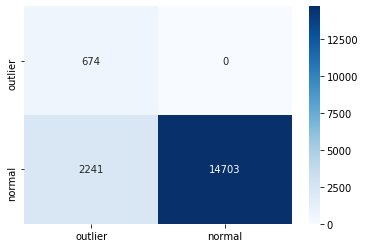

Isolation Forest AUC: 0.968


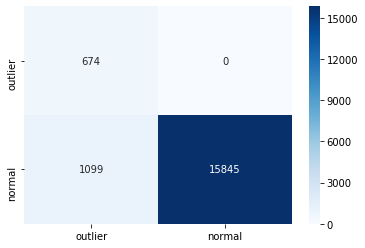

In [8]:
print(f'Similarity Forest AUC: {round(roc_auc_score(y_test, SF_preds), 3)}')
print('SF consfusion matrix:')
cm = confusion_matrix(y_test, SF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

print(f'Isolation Forest AUC: {round(roc_auc_score(y_test, IF_preds), 3)}')
cm = confusion_matrix(y_test, IF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

In order to check when outliers ranking stabilizes depending on number of estimators we call a function outliers_rank_stability, that measures Spearman correlation of ranking computed with different number of subestimators.
We check 1, 2, 3, 5, 10, 20, 30, 50, 70 and 100 trees respectively 

In this experiment, ranking becomes stable when using 30 trees

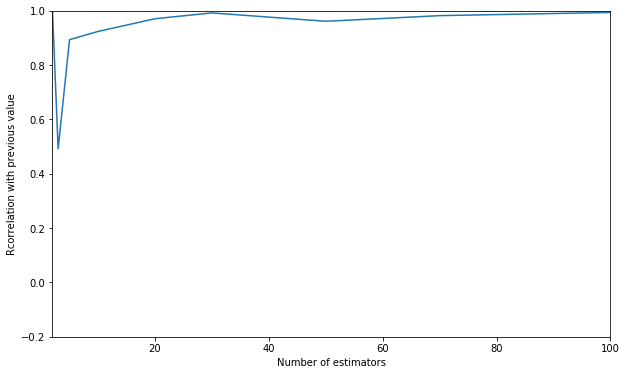

In [9]:
rcorrelations = SF.outliers_rank_stability(X_test)

# Shuttle dataset

In this dataset we have 7 different classes, from which fourth one is discarded, first one is considered normal, and all remaining represent outliers

In [10]:
dataset = fetch_openml('shuttle')
X = dataset.data
y = dataset.target
X, y = sh(X, y, random_state=1)
y = y.astype(int)
# we remove data with label 4
# normal data are then those of class 1
s = (y != 4)
X = X[s, :]
y = y[s]
y[(y == 1)] = 1
y[(y != 1)] = -1

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

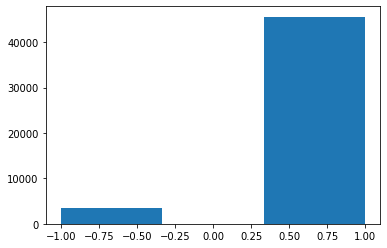

In [11]:
plt.hist(y, bins=3);

In [14]:
max_samples = 256
max_depth = int(np.ceil(np.log2(max(max_samples, 2))))
SF = SimilarityForestClassifier(random_state=42, n_estimators=100, bootstrap=False, max_samples=max_samples,
                                max_depth=max_depth, discriminative_sampling=False, most_different=False)
SF.fit(X_train, y_train)
SF_preds = SF.predict_outliers(X_test)

IF = IsolationForest(random_state=42, behaviour='new')
IF.fit(X_train, y_train)
IF_preds = IF.predict(X_test)

Similarity Forest AUC: 0.927
SF consfusion matrix:


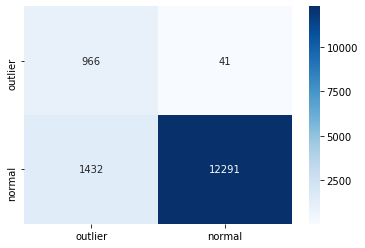

Isolation Forest AUC: 0.978


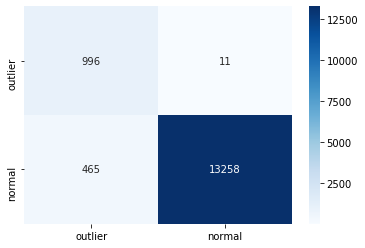

In [15]:
print(f'Similarity Forest AUC: {round(roc_auc_score(y_test, SF_preds), 3)}')
print('SF consfusion matrix:')
cm = confusion_matrix(y_test, SF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

print(f'Isolation Forest AUC: {round(roc_auc_score(y_test, IF_preds), 3)}')
cm = confusion_matrix(y_test, IF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

Similarly to previous experiment, we can see that 30 trees is enough to get stable ranking 

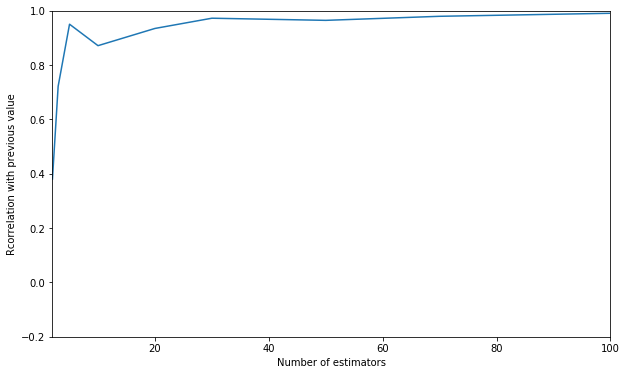

In [16]:
rcorrelations = SF.outliers_rank_stability(X_test)

# Forestcover dataset

In [17]:
dataset = fetch_covtype(shuffle=True, random_state=1)
X = dataset.data
y = dataset.target
# normal data are those with attribute 2
# abnormal those with attribute 4
s = (y == 2) + (y == 4)
X = X[s, :]
y = y[s]
y[(y == 2)] = 1
y[(y == 4)] = -1

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

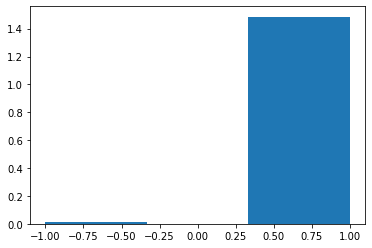

In [20]:
plt.hist(y, bins=3, density=True);

In [21]:
max_samples = 256
max_depth = int(np.ceil(np.log2(max(max_samples, 2))))
SF = SimilarityForestClassifier(random_state=42, n_estimators=100, bootstrap=False, max_samples=max_samples,
                                max_depth=max_depth, discriminative_sampling=False, most_different=False)
SF.fit(X_train, y_train)
SF_preds = SF.predict_outliers(X_test)

IF = IsolationForest(random_state=42)
IF.fit(X_train, y_train)
IF_preds = IF.predict(X_test)

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Similarity Forest AUC: 0.55
SF consfusion matrix:


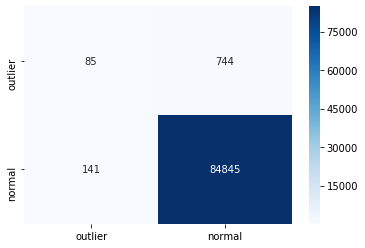

Isolation Forest AUC: 0.935


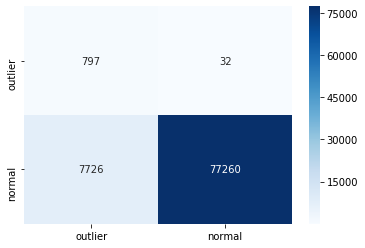

In [22]:
print(f'Similarity Forest AUC: {round(roc_auc_score(y_test, SF_preds), 3)}')
print('SF consfusion matrix:')
cm = confusion_matrix(y_test, SF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

print(f'Isolation Forest AUC: {round(roc_auc_score(y_test, IF_preds), 3)}')
cm = confusion_matrix(y_test, IF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

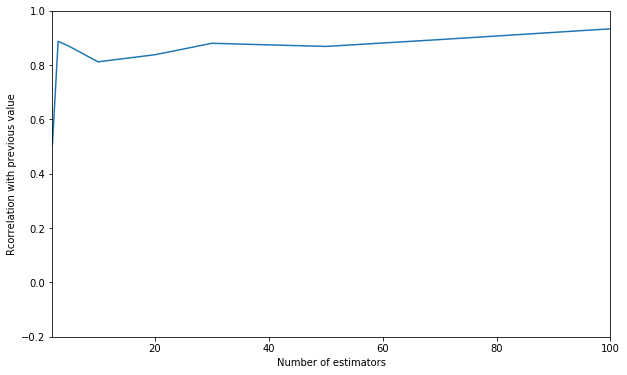

In [23]:
rcorrelations = SF.outliers_rank_stability(X_test)

In case we know how much contamination we can expect in the dataset, we can set contamination parameter, which is a fraction of objects that should be considered outliers

In [24]:
max_samples = 256
max_depth = int(np.ceil(np.log2(max(max_samples, 2))))
SF = SimilarityForestClassifier(random_state=42, n_estimators=100, bootstrap=False, max_samples=max_samples,
                                max_depth=max_depth, discriminative_sampling=False, most_different=False,
                                contamination=0.1)
SF.fit(X_train, y_train)
SF_preds = SF.predict_outliers(X_test)

IF = IsolationForest(random_state=42)
IF.fit(X_train, y_train)
IF_preds = IF.predict(X_test)

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Similarity Forest AUC: 0.787
SF consfusion matrix:


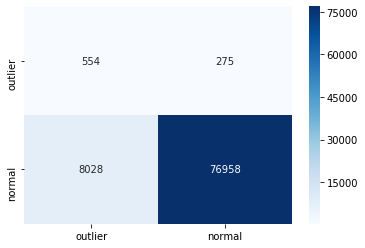

Isolation Forest AUC: 0.935


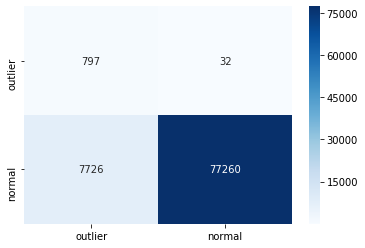

In [25]:
print(f'Similarity Forest AUC: {round(roc_auc_score(y_test, SF_preds), 3)}')
print('SF consfusion matrix:')
cm = confusion_matrix(y_test, SF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

print(f'Isolation Forest AUC: {round(roc_auc_score(y_test, IF_preds), 3)}')
cm = confusion_matrix(y_test, IF_preds)
df_cm = pd.DataFrame(cm, index = ['outlier', 'normal'], columns = ['outlier', 'normal'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');
plt.show()

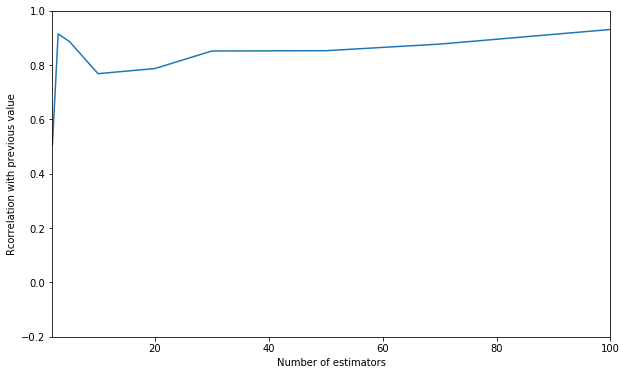

In [26]:
rcorrelations = SF.outliers_rank_stability(X_test)